# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

# My answers:

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline




df = pd.read_csv('human_body_temperature.csv')

df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


### Task 1: Is the distribution of body temperatures normal?

To answer this question, let's first construct a PDF of the data and compare it to both the theoretical PDF of what we'd expect plus a box plot to help further visualize the spread and also illuminate any possible outliers.

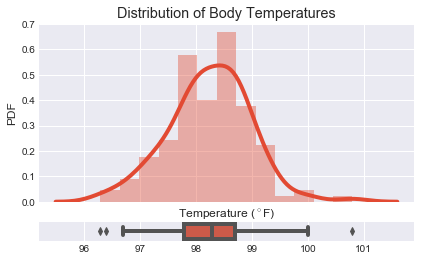

In [130]:
plt.style.use('seaborn-darkgrid')

# Create a figure with two plots:
fig, (histogram, boxplot) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.9, .1)})

# Add PDF
sns.distplot(df.temperature, ax=histogram)

# Add boxplot
sns.boxplot(df.temperature, ax=boxplot)

# Add labels and title
histogram.set(title = 'Distribution of Body Temperatures', ylabel = 'PDF', xlabel = 'Temperature ($^\circ$F)')

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='')

# Display the plots:
plt.show()

While the box plot suggests we have a few outliers in this dataset, the PDF nonetheless appears to *roughly* fit a normal distribution. Comparing a CDF of the data with the ECDF will help us confirm this claim. To do this, we first have to define a ECDF function.

In [131]:
# as seen in DataCamp lectures:

def ecdf(data):
    
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

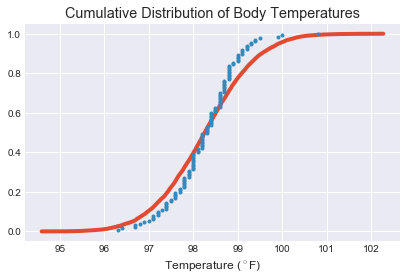

In [132]:
np.random.seed(1)

samples = np.random.normal(np.mean(df.temperature), size=10000)
x, y = ecdf(df.temperature)
x_theor, y_theor = ecdf(samples)
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
_ = plt.title('Cumulative Distribution of Body Temperatures')
_ = plt.xlabel('Temperature ($^\circ$F)')
plt.show()

Like the PDF, this ECDF appears to *roughly* fit what we'd expect, though the variation from the expected CDF shows we may not be drawing from a perfectly normal distribution.

### Task 2: Is the sample size large enough? Are the observations independent of each other?

In [133]:
n = len(df)
print('Sample size =', n)

Sample size = 130


With 130 or (n > 30) observations, we have a large enough sample size for the purposes of the Central Limit Theorem. 

We can reasonably assume that the data -- taken from the Journal of the
American Medical Association -- from each test subject (observation) is independent from that of other subjects.

### Task 3: Is the true population mean really 98.6 degrees F?

We'll first try a bootstrap method in which we'll generate many datasets from the given data, while assuming that the our null hypotheses is true, and calculate the probability that we could have obtained a dataset as extreme as the one we did (sample mean = 98.25). Let our null hypothesis state that the true population mean is equal to 98.6 degrees Fahrenheit and let alpha = 0.01 . 

In [134]:
# Define bootstrap functions:

def replicate(data, function):
    
    # Create the resampled array and return the statistic of interest:
    return function(np.random.choice(data, size=len(data)))


def draw_replicates(data, function, size=1):

    # Initialize array of replicates:
    replicates = np.empty(size)

    # Generate replicates:
    for i in range(size):
        replicates[i] = replicate(data, function)

    return replicates


# Seed the random number generator
np.random.seed(1)

# Make an array of translated temperatures
translated_temps = df.temperature - np.median(df.temperature) + 98.6

# Draw bootstrap replicates of translated temperatures
translated_replicates = draw_replicates(translated_temps, np.mean, 10000)

# Compute fraction of replicates that are less than the observed temperature mean
p = np.sum(translated_replicates <= np.median(df.temperature)) / len(translated_replicates)

# Print the p-value:
print('p-value =', p)

p-value = 0.0001


Since this probability is clearly below our alpha level, we will initially reject our null hypothesis. 

Let's next perform a one-sample T test (opposed to a one-sample Z test, for which we would need to know the population standard deviation) and then create a 99.9 percent confidence interval for t*. We're using a one-sample test opposed to a two-sample test since we're only drawing from one population and testing whether our parameter (mean) is equivalent to the known population mean (98.6 degrees Fahrenheit).

Let our null hypothesis state again that the true population mean is equal to 98.6 degrees Fahrenheit. Let alpha again equal 0.01.

In [135]:
from scipy import stats

# perform one-sample T test

t = stats.ttest_1samp(df.temperature, 98.6)[0]
p = stats.ttest_1samp(df.temperature, 98.6)[1]

print('t* =', t)
print('p-value =', p)
print('99.9% Confidence Interval = [', (stats.t.ppf(q=0.0005, df=n-1)), ',',(stats.t.ppf(q=0.9995, df=n-1)), ']')

t* = -5.4548232923645195
p-value = 2.4106320415561276e-07
99.9% Confidence Interval = [ -3.3675464541818454 , 3.367546454181878 ]


If our null hypothesis is true, we would expect to get a result as extreme as the one obtained from our sample roughly 0.0000241% of the time. Since this value is smaller than our alpha level, we can again reject the null hypothesis and conclude our evidence doesn't suggest the true population mean is 98.6 degrees Fahrenheit. This decision is further supported by the fact t* falls firmly out of our confidence interval.

In [136]:
# perform one-sample Z Test
z = (np.mean(df.temperature) - 98.6) / (np.std(df.temperature)/np.sqrt(len(df.temperature)))

# Calculate and save p-value:
p = stats.norm.cdf(z) * 2

# Print the values for z and p:
print('z* =', z)
print('p-value =', p)

z* = -5.475925202078116
p-value = 4.3523151658821886e-08


If we assume our sample standard deviation reasonably represents our population standard deviation and subsequently carry out a Z test for our data, we achieve a similar test statistic to that from our T test, but with an even lower p-value. The difference between the results reflects the nature of the two distributions, where the T distribution is calculated without knowledge of the population standard deviation and consequently gives less precise results. Regardless, we again achieved a p-value below our alpha level and now have even more evidence to reject the null hypothesis.

### Task 4: Draw a small sample of size 10 from the data and repeat both frequentist tests

In [137]:
# Draw a random sample of 10 from the temperature data
sample = np.random.choice(df.temperature, size=10)
sample

array([98. , 97.8, 98.4, 99.1, 98.2, 97.8, 97.4, 97.8, 98.2, 97.5])

In [138]:
t = stats.ttest_1samp(sample, 98.6)[0]
p = stats.ttest_1samp(sample, 98.6)[1]

print('t* =', t)
print('p-value =', p)

t* = -3.7300942268494723
p-value = 0.004696784229237778


In [139]:
z = (np.mean(sample) - 98.6) / (np.std(sample)/np.sqrt(len(sample)))
p = stats.norm.cdf(z) * 2

# Print the values for z and p:
print('z* =', z)
print('p-value =', p)

z* = -3.9318645479630434
p-value = 8.428955654324551e-05


Which one is the correct one to use?

Since we don't know the population standard deviation and now have a sample size that doesn't meet the n > 30 rule of thumb, the T test is clearly the more appropriate way to go. While both would reject the null at as low as the 0.005 alpha level, the Z test calculates a far more extreme value under the assuption that this new sample standard deviation is representative of the population.

### Task 5: At what temperature should we consider someone's temperature to be "abnormal"?

In [140]:
from scipy.stats import norm

# Calculate standard deviation
s = np.std(df.temperature)
# Calculate standard error of the mean
sem = s/np.sqrt(n)

# Define critical value for 95 % confidence interval
z_critical = norm.ppf(0.975) # two tailed

print('Standard Error of the Mean (SEM) =', sem)

# Calculate and save the margin of error:
moe = z_critical * sem
print('Margin of Error (MOE) =', moe)

CI = np.array([np.mean(df.temperature) - moe, np.mean(df.temperature) + moe])
print('95% Confidence Interval =', CI)

Standard Error of the Mean (SEM) = 0.06405661469519336
Margin of Error (MOE) = 0.12554865777413815
95% Confidence Interval = [98.12368211 98.37477943]


The SEM measures how far the sample mean is likely to be from the true population mean (compared to the standard deviation, which measures the average variability for the datapoints in a dataset relative to its mean).

The MOE is a measure that puts the SEM in terms of our desired confidence level. This result is used to calculate our confidence interval, for which the MOE represents half of the width.

The resulting confidence interval gives us a range of plausible values for the population mean at our stated confidence level. However, this doesn't give us the range of plausible values for an individual draw from the population, from which we could determine if someone has an 'abnormal' temperature. For that, we should construct a prediction interval, which provides a range of values that predicts the value of a new observation. Observations beyond the limits of this range should be considered abnormal.

In [141]:
PI = stats.norm.interval(0.999, loc=np.mean(df.temperature), scale=np.std(df.temperature))
print('99.9% Prediction Interval:', PI)

99.9% Prediction Interval: (95.8459689741907, 100.65249256427087)


We'd expect 99.9 percent of new observations to land within this range. However, this might be too strict of a definition and we should consider allowing a 95 percent prediction interval to define what will consider an abnormal temperature.

In [142]:
PI = stats.norm.interval(0.95, loc=np.mean(df.temperature), scale=np.std(df.temperature))
print('95% Prediction Interval:', PI)

95% Prediction Interval: (96.81775582674824, 99.68070571171332)


This new interval is more sensitive to outliers and other values society would likely consider abnormal.

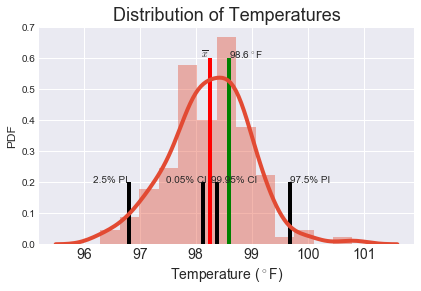

In [143]:
sns.distplot(df.temperature)

# Increase tick mark font size, label axes and add title:
plt.tick_params(axis='x', which='major', labelsize=14)
plt.xlabel('Temperature ($^\circ$F)', fontsize=14)
plt.ylabel('PDF')
plt.title('Distribution of Temperatures', fontsize=18)

# Add text and lines marking the 99.9% confidence interval:
plt.text(x=CI[0]-0.65, y=0.2, s='0.05% CI')
plt.vlines(ymin=0, ymax=0.2, x=CI[0])
plt.text(x=CI[1]-0.1, y=0.2, s='99.95% CI')
plt.vlines(ymin=0, ymax=0.2, x=CI[1])

# Add a lines for different means:
plt.text(x=M-0.15, y=0.6, s='$\overline{x}$')
plt.vlines(ymin=0, ymax=0.6, x=M, color='red')
plt.text(x=98.6, y=0.6, s='98.6$^\circ$F')
plt.vlines(ymin=0, ymax=0.6, x=98.6, color='green')

# Add text and lines marking the 95% prediction interval:
plt.text(x=PI[0]-0.65, y=0.2, s='2.5% PI')
plt.vlines(ymin=0, ymax=0.2, x=PI[0])
plt.text(x=PI[1], y=0.2, s='97.5% PI')
plt.vlines(ymin=0, ymax=0.2, x=PI[1])

# Remove x-axis label for the boxplot:
boxplot.set(xlabel='')

# Display the plots:
plt.show()

The above figure allows us to compare the 99.9% confidence interval with the 95% prediction interval. 

In [144]:
abnormal_upper = df.temperature > PI[1]
abnormal_lower = df.temperature < PI[0]
filters = abnormal_upper | abnormal_lower
df[filters]

,temperature,gender,heart_rate
11,96.7,F,62.0
39,96.4,F,69.0
91,100.0,F,78.0
95,96.8,F,75.0
96,99.9,F,79.0
105,96.7,M,71.0
116,100.8,F,77.0
125,96.3,M,70.0


From this definition of ours, we would view eight of the 130 observations to be 'abnormal'. 

In [145]:
8/130

0.06153846153846154

### Task 6: Is there a significant difference between males and females in normal temperature?

In [146]:
print('Number of men in study:', len(df[df.gender == 'M']))
print('Average male body temp:', np.mean(df.temperature[df.gender == 'M']))
print('Number of women in study:', len(df[df.gender == 'F']))
print('Average female body temp:', np.mean(df.temperature[df.gender == 'F']))

Number of men in study: 65
Average male body temp: 98.1046153846154
Number of women in study: 65
Average female body temp: 98.39384615384613


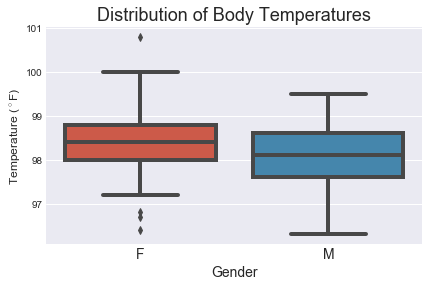

In [147]:
# Create boxplots for temperature by gender:
fig = sns.boxplot(x='gender', y='temperature', data=df)

# Increase tick mark font size, label axes and add title:
plt.tick_params(axis='x', which='major', labelsize=14)
fig = plt.xlabel('Gender', fontsize=14)
fig = plt.ylabel('Temperature ($^\circ$F)')
plt.title('Distribution of Body Temperatures', fontsize=18)

# Display the plots:
plt.show()

Having both n>30 samples for each of men and women, we have large enough sample sizes to use either a Z or T test to assess whether there's a difference (in terms of average body temp) for each group. Judging by the displayed box plot, we have reason to suspect there is one.

Now we'll run a T test at a 0.05 alpha level under the null hypothesis that there is no difference between the average male and female body temperatures.

In [148]:
female_temp = df.temperature[df.gender == 'F']
male_temp = df.temperature[df.gender == 'M']

t = stats.ttest_ind(female_temp, male_temp)[0]
p = stats.ttest_ind(female_temp, male_temp)[1]

print('t* =', t)
print('p-value =', p)
print('95% CI =', (stats.t.ppf(q=0.025, df=65-1)), (stats.t.ppf(q=0.975, df=65-1)))

t* = 2.2854345381656103
p-value = 0.02393188312239561
95% CI = -1.9977296536259739 1.9977296536259734


As we suspected, our T test would lead us to reject the null hypothesis and conclude that we have the evidence to suggest there is a difference between the average male and female body temperature.